# Part 2, XGBoost

In [6]:
import xgboost as xgb
import pandas as pd
import numpy as np
import pickle
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from scipy.sparse import csr_matrix, hstack
from sklearn.model_selection import KFold, train_test_split
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# This may raise an exception in earlier versions of Jupyter
%config InlineBackend.figure_format = 'retina'

## Data Pre-process

In [7]:
train = pd.read_csv('train.csv')
train['log_loss'] = np.log(train['loss'])

In [8]:
features = [x for x in train.columns if x not in ['id','loss', 'log_loss']]

cat_features = [x for x in train.select_dtypes(
        include=['object']).columns if x not in ['id','loss', 'log_loss']]
num_features = [x for x in train.select_dtypes(
        exclude=['object']).columns if x not in ['id','loss', 'log_loss']]

print ("Categorical features:", len(cat_features))
print ("Numerical features:", len(num_features))

Categorical features: 116
Numerical features: 14


And use a label encoder for categorical features:

In [9]:
ntrain = train.shape[0]

train_x = train[features]
train_y = train['log_loss']

for c in range(len(cat_features)):
    train_x[cat_features[c]] = train_x[cat_features[c]].astype('category').cat.codes
    
print ("Xtrain:", train_x.shape)
print ("ytrain:", train_y.shape)

Xtrain: (188318, 130)
ytrain: (188318,)


## Simple XGBoost Model

First, let's build an simple XGBoost model, then perform parameter adjustment through cross-validation to observe the transformation of the results, using the mean absolute error to measure.

In [10]:
def xg_eval_mae(yhat, dtrain):
    y = dtrain.get_label()
    return 'mae', mean_absolute_error(np.exp(y), np.exp(yhat))

### XBGoost Dmatrix 

In [15]:
dtrain = xgb.DMatrix(train_x, train['log_loss'])

In [29]:
xgb_params = {
    'seed': 0,
    'eta': 0.1,
    'colsample_bytree': 0.5,
    'subsample': 0.5,
    'objective': 'reg:linear',
    'max_depth': 5,
    'min_child_weight': 3,
    'verbosity': 0
}

In [30]:
%%time
bst_cv1 = xgb.cv(xgb_params, dtrain, num_boost_round=50, nfold=3, seed=0, 
                 feval=xg_eval_mae, maximize=False, early_stopping_rounds=10)

print ('CV score:', bst_cv1.iloc[-1,:]['test-mae-mean'])

CV score: 1220.1099853333333
Wall time: 17.7 s


### Here we got the benchmark results：MAE＝1220

<Figure size 432x288 with 0 Axes>

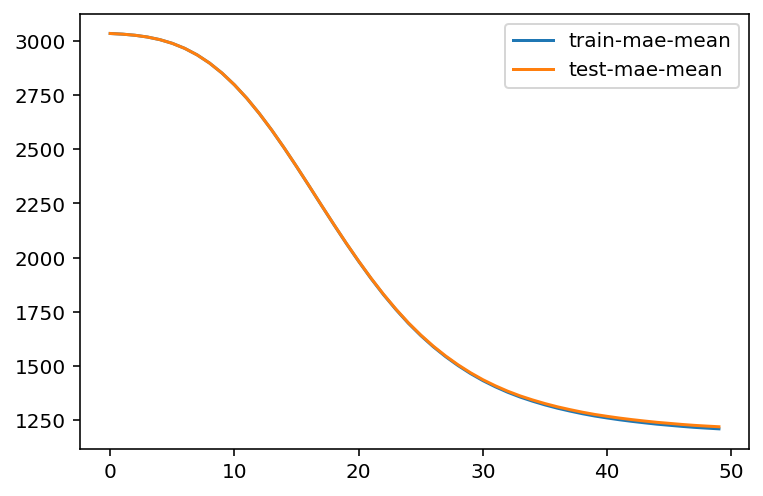

In [21]:
plt.figure()
bst_cv1[['train-mae-mean', 'test-mae-mean']].plot()

### Summary for the first model：

* num_boost_round =50
* no over-fitting

In [22]:
%%time
bst_cv2 = xgb.cv(xgb_params, dtrain, num_boost_round=100, nfold=3, seed=0, 
                 feval=xg_eval_mae, maximize=False, early_stopping_rounds=10)

print ('CV score:', bst_cv2.iloc[-1,:]['test-mae-mean'])

[13:34:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[13:34:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[13:34:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
CV score: 1172.059570333333
Wall time: 36.1 s


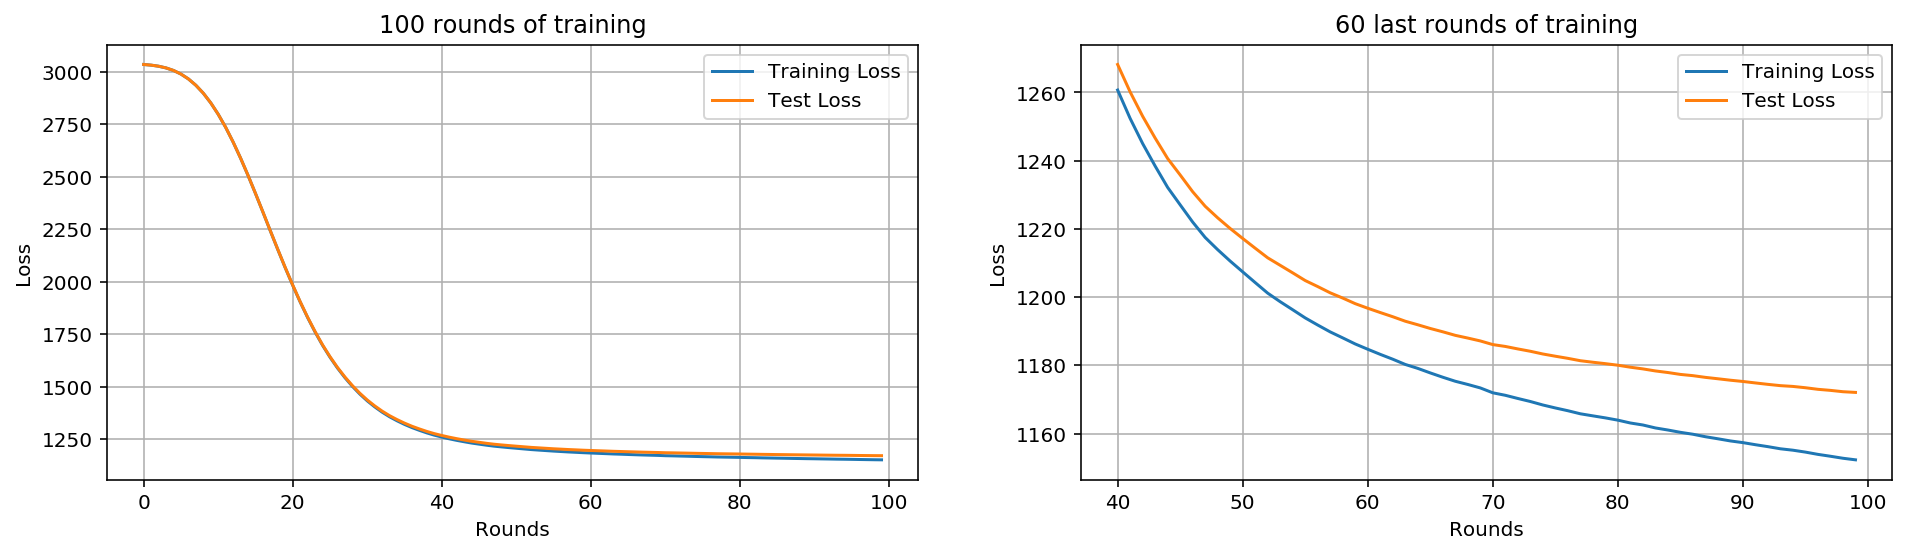

In [23]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(16,4)

ax1.set_title('100 rounds of training')
ax1.set_xlabel('Rounds')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.plot(bst_cv2[['train-mae-mean', 'test-mae-mean']])
ax1.legend(['Training Loss', 'Test Loss'])

ax2.set_title('60 last rounds of training')
ax2.set_xlabel('Rounds')
ax2.set_ylabel('Loss')
ax2.grid(True)
ax2.plot(bst_cv2.iloc[40:][['train-mae-mean', 'test-mae-mean']])
ax2.legend(['Training Loss', 'Test Loss'])

### Summary for the second model：

* num_boost_round =100
* a little over-fitting
* better MAE = 1172

## XGBoost Hyper-parameter tuning

In [31]:
class XGBoostRegressor(object):
    def __init__(self, **kwargs):
        self.params = kwargs
        if 'num_boost_round' in self.params:
            self.num_boost_round = self.params['num_boost_round']
        self.params.update({'verbosity': 0, 'objective': 'reg:linear', 'seed': 0})
        
    def fit(self, x_train, y_train):
        dtrain = xgb.DMatrix(x_train, y_train)
        self.bst = xgb.train(params=self.params, dtrain=dtrain, num_boost_round=self.num_boost_round,
                             feval=xg_eval_mae, maximize=False)
        
    def predict(self, x_pred):
        dpred = xgb.DMatrix(x_pred)
        return self.bst.predict(dpred)
    
    def kfold(self, x_train, y_train, nfold=5):
        dtrain = xgb.DMatrix(x_train, y_train)
        cv_rounds = xgb.cv(params=self.params, dtrain=dtrain, num_boost_round=self.num_boost_round,
                           nfold=nfold, feval=xg_eval_mae, maximize=False, early_stopping_rounds=10)
        return cv_rounds.iloc[-1,:]
    
    def plot_feature_importances(self):
        feat_imp = pd.Series(self.bst.get_fscore()).sort_values(ascending=False)
        feat_imp.plot(title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        
    def get_params(self, deep=True):
        return self.params
 
    def set_params(self, **params):
        self.params.update(params)
        return self

In [32]:
def mae_score(y_true, y_pred):
    return mean_absolute_error(np.exp(y_true), np.exp(y_pred))

mae_scorer = make_scorer(mae_score, greater_is_better=False)

In [33]:
bst = XGBoostRegressor(eta=0.1, colsample_bytree=0.5, subsample=0.5, 
                       max_depth=5, min_child_weight=3, num_boost_round=50)

In [34]:
bst.kfold(train_x, train_y, nfold=5)

train-rmse-mean       0.558938
train-rmse-std        0.001005
test-rmse-mean        0.562665
test-rmse-std         0.002445
train-mae-mean     1209.707324
train-mae-std         3.004207
test-mae-mean      1218.884204
test-mae-std          8.982969
Name: 49, dtype: float64

### Step 1: Choose right values of max_depth and min_child_weight

In [35]:
xgb_param_grid = {'max_depth': list(range(4,9)), 'min_child_weight': list((1,3,6))}
xgb_param_grid['max_depth']

[4, 5, 6, 7, 8]

In [36]:
%%time
 
grid = GridSearchCV(XGBoostRegressor(eta=0.1, num_boost_round=50, colsample_bytree=0.5, subsample=0.5),
                param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)

grid.fit(train_x, train_y.values)

Wall time: 12min 39s


GridSearchCV(cv=5, error_score=nan,
             estimator=<__main__.XGBoostRegressor object at 0x000001F60DAAC3C8>,
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [4, 5, 6, 7, 8],
                         'min_child_weight': [1, 3, 6]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(mae_score, greater_is_better=False),
             verbose=0)

In [38]:
grid.cv_results_, grid.best_params_, grid.best_score_

({'mean_fit_time': array([ 5.99509068,  6.49593172,  6.57089062,  7.73033624,  7.71181564,
          7.70864825,  9.15811625,  9.19540114,  9.23384705, 11.87470603,
         11.7900362 , 11.67740841, 14.0763567 , 14.05789375, 13.60267649]),
  'std_fit_time': array([0.64188013, 0.06621568, 0.07598157, 0.04708269, 0.10534966,
         0.1001259 , 0.10427401, 0.13433145, 0.26103568, 1.21774832,
         0.48929851, 0.48573366, 0.74125935, 0.8375911 , 1.2205627 ]),
  'mean_score_time': array([0.12806196, 0.13037844, 0.12589116, 0.12457123, 0.12990341,
         0.12777061, 0.13021927, 0.14276299, 0.12915707, 0.13121853,
         0.13031244, 0.13221874, 0.14116635, 0.14031725, 0.1456636 ]),
  'std_score_time': array([0.00733644, 0.00685454, 0.01116964, 0.00991204, 0.00986416,
         0.01135551, 0.00711829, 0.00367712, 0.01338893, 0.0124969 ,
         0.00538457, 0.01250082, 0.01626667, 0.0130135 , 0.01744629]),
  'param_max_depth': masked_array(data=[4, 4, 4, 5, 5, 5, 6, 6, 6, 7, 7, 7, 8, 

### Here best results from grid search:

 {'max_depth': 8, 'min_child_weight': 6},  -1187.5361330370838)

### Step 2: adjust gamma 

In [51]:
%%time

xgb_param_grid = {'gamma':[ 0.1 * i for i in range(0,5)]}

grid = GridSearchCV(XGBoostRegressor(eta=0.1, num_boost_round=50, max_depth=8, min_child_weight=6,
                                        colsample_bytree=0.5, subsample=0.5),
                    param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)

grid.fit(train_x, train_y.values)

Wall time: 5min 10s


GridSearchCV(cv=5, error_score=nan,
             estimator=<__main__.XGBoostRegressor object at 0x000001F60DB17208>,
             iid='deprecated', n_jobs=None,
             param_grid={'gamma': [0.0, 0.1, 0.2, 0.30000000000000004, 0.4]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(mae_score, greater_is_better=False),
             verbose=0)

In [52]:
grid.cv_results_, grid.best_params_, grid.best_score_

({'mean_fit_time': array([10.69411979, 11.92112498, 12.03027077, 11.9684968 , 11.88204069]),
  'std_fit_time': array([0.96398581, 0.14012133, 0.21093522, 0.11506475, 0.2253064 ]),
  'mean_score_time': array([0.1252068 , 0.12587457, 0.13507752, 0.12733974, 0.11974478]),
  'std_score_time': array([0.01092913, 0.01042133, 0.01202216, 0.00303938, 0.00660004]),
  'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.30000000000000004, 0.4],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'gamma': 0.0},
   {'gamma': 0.1},
   {'gamma': 0.2},
   {'gamma': 0.30000000000000004},
   {'gamma': 0.4}],
  'split0_test_score': array([-1185.1048085 , -1183.97135463, -1184.11196007, -1183.8566163 ,
         -1185.76969705]),
  'split1_test_score': array([-1184.26136824, -1184.13614688, -1184.36920151, -1183.19854309,
         -1182.52920777]),
  'split2_test_score': array([-1195.96191412, -1196.46500824, -1196.57859815, -1196.8301

### Here we should choose small value of gamma

### Step 3: Grid search subsample and colsample_bytree

In [53]:
%%time

xgb_param_grid = {'subsample':[ 0.1 * i for i in range(6,9)],
                      'colsample_bytree':[ 0.1 * i for i in range(6,9)]}


grid = GridSearchCV(XGBoostRegressor(eta=0.1, gamma=0.2, num_boost_round=50, max_depth=8, min_child_weight=6),
                    param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)
grid.fit(train_x, train_y.values)

Wall time: 11min 36s


GridSearchCV(cv=5, error_score=nan,
             estimator=<__main__.XGBoostRegressor object at 0x000001F60DB17D48>,
             iid='deprecated', n_jobs=None,
             param_grid={'colsample_bytree': [0.6000000000000001,
                                              0.7000000000000001, 0.8],
                         'subsample': [0.6000000000000001, 0.7000000000000001,
                                       0.8]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(mae_score, greater_is_better=False),
             verbose=0)

In [54]:
grid.cv_results_, grid.best_params_, grid.best_score_

({'mean_fit_time': array([13.88172097, 13.39400849, 13.46746716, 15.35793505, 15.26029053,
         14.20743971, 16.34301839, 16.65993743, 15.55538588]),
  'std_fit_time': array([0.45981364, 0.19300994, 0.65506396, 0.23472147, 0.59556053,
         0.05357774, 0.21789277, 0.87544623, 0.07854112]),
  'mean_score_time': array([0.13827815, 0.12749166, 0.12142673, 0.13076444, 0.12874918,
         0.12184505, 0.12809334, 0.13121729, 0.12184548]),
  'std_score_time': array([0.01060947, 0.00504448, 0.00758469, 0.00688277, 0.00605528,
         0.01530495, 0.00624759, 0.01249609, 0.00624919]),
  'param_colsample_bytree': masked_array(data=[0.6000000000000001, 0.6000000000000001,
                     0.6000000000000001, 0.7000000000000001,
                     0.7000000000000001, 0.7000000000000001, 0.8, 0.8, 0.8],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_subsample': mas

### Here we get results as: 
{'colsample_bytree': 0.8, 'subsample': 0.8}, -1182.6715795030143)

### Step 4: reduce the learning rate and increase the number of trees

First, we plot different learning rates for a base model (50 trees):

In [56]:
%%time
    
xgb_param_grid = {'eta':[0.5,0.4,0.3,0.2,0.1,0.075,0.05,0.04,0.03]}
grid = GridSearchCV(XGBoostRegressor(num_boost_round=50, gamma=0.2, max_depth=8, min_child_weight=6,
                                        colsample_bytree=0.6, subsample=0.9),
                    param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)

grid.fit(train_x, train_y.values)

Wall time: 9min 19s


GridSearchCV(cv=5, error_score=nan,
             estimator=<__main__.XGBoostRegressor object at 0x000001F60DB17B08>,
             iid='deprecated', n_jobs=None,
             param_grid={'eta': [0.5, 0.4, 0.3, 0.2, 0.1, 0.075, 0.05, 0.04,
                                 0.03]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(mae_score, greater_is_better=False),
             verbose=0)

In [57]:
grid.cv_results_, grid.best_params_, grid.best_score_

({'mean_fit_time': array([10.5064249 , 11.91825733, 12.00090547, 12.10027008, 12.21045442,
         12.79570565, 12.16986918, 12.14873672, 11.85061717]),
  'std_fit_time': array([0.95097081, 0.14226368, 0.14783638, 0.10104393, 0.0634697 ,
         0.61487905, 0.1874211 , 0.285577  , 0.11678837]),
  'mean_score_time': array([0.11214471, 0.13544493, 0.12496953, 0.12497039, 0.11872139,
         0.1280942 , 0.12063403, 0.14242458, 0.12809663]),
  'std_score_time': array([0.00644344, 0.00878556, 0.00987948, 0.00987835, 0.00765144,
         0.01530548, 0.0067216 , 0.00357181, 0.01168898]),
  'param_eta': masked_array(data=[0.5, 0.4, 0.3, 0.2, 0.1, 0.075, 0.05, 0.04, 0.03],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'params': [{'eta': 0.5},
   {'eta': 0.4},
   {'eta': 0.3},
   {'eta': 0.2},
   {'eta': 0.1},
   {'eta': 0.075},
   {'eta': 0.05},
   {'eta': 0.04},
   {'eta': 0.0

### Here we have best results as: 
{'eta': 0.2},  -1159.622770516005)

### Now with the tree number of 100:

In [58]:
xgb_param_grid = {'eta':[0.5,0.4,0.3,0.2,0.1,0.075,0.05,0.04,0.03]}
grid = GridSearchCV(XGBoostRegressor(num_boost_round=100, gamma=0.2, max_depth=8, min_child_weight=6,
                                        colsample_bytree=0.6, subsample=0.9),
                    param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)

grid.fit(train_x, train_y.values)

GridSearchCV(cv=5, error_score=nan,
             estimator=<__main__.XGBoostRegressor object at 0x000001F60DB026C8>,
             iid='deprecated', n_jobs=None,
             param_grid={'eta': [0.5, 0.4, 0.3, 0.2, 0.1, 0.075, 0.05, 0.04,
                                 0.03]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(mae_score, greater_is_better=False),
             verbose=0)

In [59]:
grid.cv_results_, grid.best_params_, grid.best_score_

({'mean_fit_time': array([21.67646217, 24.86515956, 23.01337614, 23.20435877, 23.78632073,
         23.94677653, 24.02629852, 23.99737253, 23.93073816]),
  'std_fit_time': array([1.89820133, 2.52527004, 0.12214133, 0.15758171, 0.11031773,
         0.13983249, 0.14798912, 0.09397252, 0.17826016]),
  'mean_score_time': array([0.12009788, 0.13745198, 0.13120456, 0.12495475, 0.1376586 ,
         0.13003416, 0.1251184 , 0.13794837, 0.13575535]),
  'std_score_time': array([6.34189786e-03, 1.16955313e-02, 7.66227685e-03, 1.50324001e-05,
         6.35820712e-03, 1.33872595e-02, 6.36480885e-04, 1.25117974e-02,
         7.02732342e-03]),
  'param_eta': masked_array(data=[0.5, 0.4, 0.3, 0.2, 0.1, 0.075, 0.05, 0.04, 0.03],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'params': [{'eta': 0.5},
   {'eta': 0.4},
   {'eta': 0.3},
   {'eta': 0.2},
   {'eta': 0.1},
   {'eta': 0.075},
   {'

### Now with the tree number of 200:

In [60]:
%%time

xgb_param_grid = {'eta':[0.09,0.08,0.07,0.06,0.05,0.04]}
grid = GridSearchCV(XGBoostRegressor(num_boost_round=200, gamma=0.2, max_depth=8, min_child_weight=6,
                                        colsample_bytree=0.6, subsample=0.9),
                    param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)

grid.fit(train_x, train_y.values)

Wall time: 24min 31s


GridSearchCV(cv=5, error_score=nan,
             estimator=<__main__.XGBoostRegressor object at 0x000001F60DB0EE88>,
             iid='deprecated', n_jobs=None,
             param_grid={'eta': [0.09, 0.08, 0.07, 0.06, 0.05, 0.04]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(mae_score, greater_is_better=False),
             verbose=0)

In [62]:
grid.cv_results_, grid.best_params_, grid.best_score_

({'mean_fit_time': array([44.3441186 , 46.92711091, 47.10510883, 47.75666847, 47.85543475,
         47.87512221]),
  'std_fit_time': array([2.72178864, 1.34349269, 1.22642696, 1.14976465, 0.97730241,
         0.31764924]),
  'mean_score_time': array([0.14994912, 0.14763312, 0.14681859, 0.14992943, 0.14993629,
         0.149927  ]),
  'std_score_time': array([0.00764115, 0.01413463, 0.00764154, 0.00765203, 0.00765755,
         0.00765569]),
  'param_eta': masked_array(data=[0.09, 0.08, 0.07, 0.06, 0.05, 0.04],
               mask=[False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'eta': 0.09},
   {'eta': 0.08},
   {'eta': 0.07},
   {'eta': 0.06},
   {'eta': 0.05},
   {'eta': 0.04}],
  'split0_test_score': array([-1148.62893938, -1147.40076465, -1147.3712768 , -1147.65670841,
         -1149.08463433, -1151.88113125]),
  'split1_test_score': array([-1139.71528459, -1140.47900808, -1140.78232662, -1140.43031261,
         -1142.14

### Final Model:

In [64]:
%%time

bst = XGBoostRegressor(num_boost_round=200, eta=0.08, gamma=0.2, max_depth=8, min_child_weight=6,
                                        colsample_bytree=0.6, subsample=0.9)
cv = bst.kfold(train_x, train_y, nfold=5)

Wall time: 3min 59s


In [65]:
cv

train-rmse-mean       0.492285
train-rmse-std        0.000106
test-rmse-mean        0.537703
test-rmse-std         0.002108
train-mae-mean     1032.011353
train-mae-std         1.274384
test-mae-mean      1145.608081
test-mae-std          7.963653
Name: 199, dtype: float64

### The base model has MAE = 1200. And it goes smaller after hyperparemter tunning.
### Now here is the final model:

`XGBoostRegressor(num_boost_round=200, gamma=0.2, max_depth=8, min_child_weight=6, colsample_bytree=0.6, subsample=0.9, eta=0.08).

